In [1]:
%pylab inline
from glob import glob
import re
import getdist as gd
import dynesty as dn
import pickle as pk
from dynesty import plotting
#import bsamp

Populating the interactive namespace from numpy and matplotlib


In [2]:
import bhmf

param_names_ppisn = ['mgap', 'a', 'b', 'd', 'mmin', 'deltam']
param_names_plp = ['mmax', 'mum', 'sm', 'alpha', 'lambdap', 'mmin', 'deltam']
param_names_plp_pow = ['mmax', 'mum', 'sm', 'alpha', 'lambdap', 'mmin', 'deltam', 'k']

gwpaths1 = [x for x in glob('./all_posterior_samples/*_GWTC-1*') if 'prior' not in x]
gwpaths2 = [x for x in glob('./all_posterior_samples/*_comoving*') if 'prior' not in x]
gwtelnums = np.concatenate([[re.search('(?<=all_posterior_samples\/GW).+(?=_comoving.h5)', x)[0] for x in gwpaths2], [re.search('(?<=all_posterior_samples\/GW).+(?=_GWTC-1.hdf5)', x)[0] for x in gwpaths1]])
gwdat = [bhmf.lvc_data(x) for x in gwtelnums]

found_injections = bhmf.injection_extraction()

def u_shift(v, xl, xh):
    return v*(xh-xl) + xl

def m_u_shift(vec, xlim):
    xlow, xhigh = np.array(xlim).T
    return xlow+(xhigh-xlow)*vec

from getdist import plots, MCSamples
def get_mc_samples(res, param_names=param_names_plp):
    weights = np.exp(res.logwt - res.logz[-1])
    return MCSamples(samples=res.samples, weights = weights, names=param_names,
                    labels = [r'M_{\rm max}', r'\mu_m', r'\sigma_m', r'\alpha', r'\lambda_p',
                              r'M_{\rm min}', r'\delta_m', r'\beta_q'])

In [3]:
tp10_pen = dn.NestedSampler(lambda x: bhmf.weighted_log_likelihood(gwdat, parameters=dict(zip(param_names_plp_pow, x)),
                                                                    mass_fn = 'plp', secondary_prob='qpow', found_injection_data=found_injections),
                        lambda z: m_u_shift(z, [[30,100], [20,50], [1,10], [-4,12], [0,1], [2,10], [0,10], [-4,12]]), 8)

In [4]:
tp10_pen.run_nested(dlogz=1.0)

5186it [32:07,  2.69it/s, +500 | bound: 18 | nc: 1 | ncall: 30146 | eff(%): 18.862 | loglstar:   -inf < -295.660 <    inf | logz: -306.203 +/-  0.245 | dlogz:  0.002 >  1.000]


In [3]:
tf10_pen = dn.NestedSampler(lambda x: bhmf.weighted_log_likelihood(gwdat, parameters=dict(zip(param_names_plp, x)),
                                                                    mass_fn = 'plp', secondary_prob='qflat', found_injection_data=found_injections),
                        lambda z: m_u_shift(z, [[30,100], [20,50], [1,10], [-4,12], [0,1], [2,10], [0,10]]), 7)

In [4]:
tf10_pen.run_nested(dlogz=1.0)

5391it [1:14:02,  1.21it/s, +500 | bound: 22 | nc: 1 | ncall: 34024 | eff(%): 17.314 | loglstar:   -inf < -368.808 <    inf | logz: -379.875 +/-  0.262 | dlogz:  0.003 >  1.000]


Removed no burn in


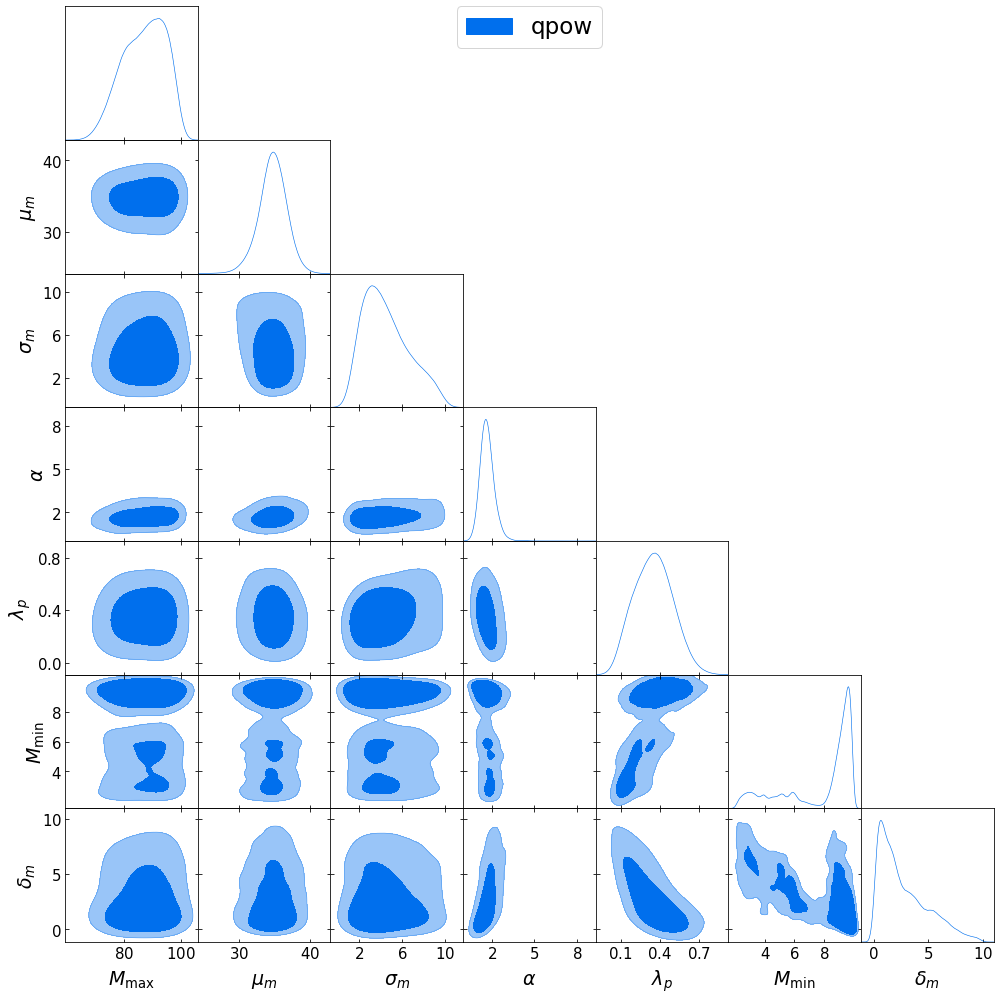

In [5]:
g = plots.get_subplot_plotter()
g.settings.title_limit_fontsize = 16 # reference size for 3.5 inch subplot
g.settings.axes_fontsize=18
g.settings.legend_fontsize = 26
g.settings.axes_labelsize = 22
g.contours = [0.90, 0.95, 0.99]
g.triangle_plot([#get_mc_samples(tp10_pen.results, param_names=param_names_plp_pow),
                 get_mc_samples(tf10_pen.results, param_names=param_names_plp)],
                filled=True, legend_labels=['qpow', 'qflat'])

In [9]:
g.export("/Users/sammcd00/Desktop/plots_mm10_pen.pdf")

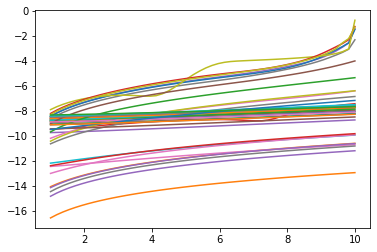

In [27]:
mmr = linspace(1,10)
for g in gwdat:
    plot(mmr, [bhmf.gw_event_log_likelihood(g,
                   parameters=dict(zip(param_names_plp, (85, 37, 3, 2.5, .1, m, 10-m))),
                   mass_fn='plp', secondary_prob='qflat') for m in mmr])
show()

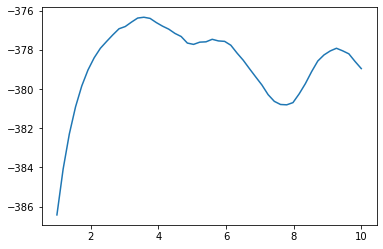

In [6]:
mmr = linspace(1,10)
plot(mmr, [bhmf.weighted_log_likelihood(gwdat,
                   parameters=dict(zip(param_names_plp, (85, 37, 3, 2.5, .1, m, 3))),
                   mass_fn='plp', secondary_prob='qflat', found_injection_data=found_injections) for m in mmr])
show()

In [4]:
ebd = load("/Users/sammcd00/Dropbox/1recently-completed-papers/42bhmf/DM_BHMG_DATA/fit_data/LIGO_chain_data/bh_data_wname_saved_temp.npy", allow_pickle=True)

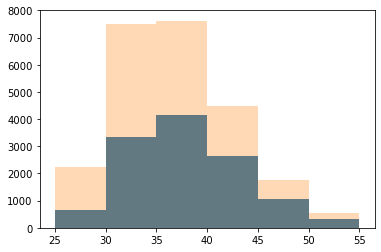

In [39]:
hist(bhmf.lvc_data("190517_055101")['mass_1_source'], bins=arange(25,60,5))
hist(ebd[0]['m12_samples'][:,0], bins=arange(25,60,5), alpha=0.3)
show()

In [8]:
nebd=[x['name'] for x in ebd]

In [27]:
nebd[4]

'GW190413_134308_comoving.h5'

In [41]:
import h5py

In [60]:
with h5py.File("/Users/sammcd00/bhmf/all_posterior_samples/GW190413_134308_comoving.h5", 'r') as f:
    m1_190413_134308_co = array(f['PublicationSamples/posterior_samples']['mass_1_source'])
with h5py.File("/Users/sammcd00/bhmf/all_posterior_samples/GW190413_134308.h5", 'r') as f:
    m1_190413_134308 = array(f['PublicationSamples/posterior_samples']['mass_1_source'])

In [64]:
mean(m1_190413_134308_co), mean(m1_190413_134308)

(48.04396962980797, 45.96612763229391)

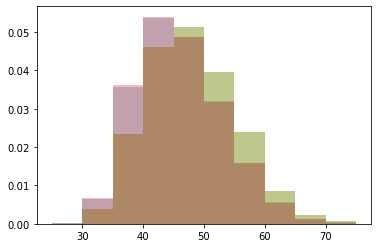

In [61]:
hist(ebd[4]['m12_samples'][:,0], bins=arange(25,80,5), alpha=0.3, density=True)
# hist(bhmf.lvc_data("190413_134308", cm=False)['mass_1_source'], bins=arange(25,80,5), alpha=0.3, density=True)
hist(bhmf.lvc_data("190413_134308")['mass_1_source'], bins=arange(25,80,5), alpha=0.3, density=True)
hist(m1_190413_134308_co, bins=arange(25,80,5), alpha=0.3, density=True)
hist(m1_190413_134308, bins=arange(25,80,5), alpha=0.3, density=True)
show()

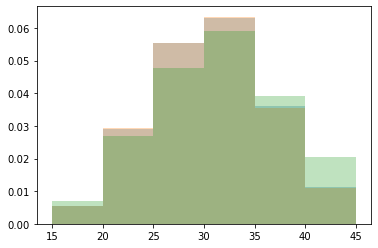

In [34]:
hist(ebd[4]['m12_samples'][:,1], bins=arange(15,50,5), alpha=0.3, density=True)
hist(bhmf.lvc_data("190413_134308", cm=False)['mass_2_source'], bins=arange(15,50,5), alpha=0.3, density=True)
hist(bhmf.lvc_data("190413_134308")['mass_2_source'], bins=arange(15,50,5), alpha=0.3, density=True)
show()

In [9]:
ebd[1]['name'], ebd[1]['m12_samples'][:,0].shape,bhmf.lvc_data("190706_222641")['mass_1_source'].shape

('GW190706_222641_comoving.h5', (24775,), (36176,))

In [14]:
with bhmf.h5py.File("all_posterior_samples/GW190706_222641_comoving.h5",'r') as f:
    print(np.array(f))

['C01:IMRPhenomD' 'C01:IMRPhenomPv2' 'C01:NRSur7dq4' 'C01:SEOBNRv4P'
 'C01:SEOBNRv4PHM' 'C01:SEOBNRv4P_nonevol' 'PrecessingSpinIMR'
 'PrecessingSpinIMRHM' 'PublicationSamples' 'ZeroSpinIMR' 'history'
 'version']


In [13]:
with bhmf.h5py.File("all_posterior_samples/GW190706_222641_comoving.h5",'r') as f:
    n = 0
    for k in ['C01:SEOBNRv4P', 'C01:NRSur7dq4', 'PrecessingSpinIMR', 'C01:SEOBNRv4PHM', 'PrecessingSpinIMRHM', 'C01:IMRPhenomPv2', 'C01:IMRPhenomD', 'ZeroSpinIMR', 'PublicationSamples']:
        nk = len(np.array(f[k]['posterior_samples']))
        n+=nk
        print(k+" "+str(nk)+" "+str(n))

C01:SEOBNRv4P 1615 1615
C01:NRSur7dq4 2832 4447
PrecessingSpinIMR 3236 7683
C01:SEOBNRv4PHM 3815 11498
PrecessingSpinIMRHM 5702 17200
C01:IMRPhenomPv2 6657 23857
C01:IMRPhenomD 7059 30916
ZeroSpinIMR 7126 38042
PublicationSamples 5536 43578


In [12]:
with bhmf.h5py.File("all_posterior_samples/GW190706_222641.h5",'r') as f:
    n = 0
    for k in ['C01:SEOBNRv4P', 'C01:NRSur7dq4', 'PrecessingSpinIMR', 'C01:SEOBNRv4PHM', 'PrecessingSpinIMRHM', 'C01:IMRPhenomPv2', 'C01:IMRPhenomD', 'ZeroSpinIMR', 'PublicationSamples']:
        nk = len(np.array(f[k]['posterior_samples']))
        n+=nk
        print(k+" "+str(nk)+" "+str(n))

C01:SEOBNRv4P 12183 12183
C01:NRSur7dq4 19720 31903
PrecessingSpinIMR 24366 56269
C01:SEOBNRv4PHM 18088 74357
PrecessingSpinIMRHM 36176 110533
C01:IMRPhenomPv2 48039 158572
C01:IMRPhenomD 43466 202038
ZeroSpinIMR 43466 245504
PublicationSamples 36176 281680


In [96]:
with bhmf.h5py.File("all_posterior_samples/GW170729_GWTC-1.hdf5",'r') as f:
    print(np.array(f['Overall_posterior']['m1_detector_frame_Msun']).shape)

(5112,)


In [164]:
for x in ebd:
    if x['name'] not in ''.join(gwpaths2):
        print(x['name'])

GW190909_114149_comoving.h5
GW190719_215514_comoving.h5
GW190426_152155_comoving.h5
GW190814_comoving.h5


In [168]:
'190425' in ''.join([x['name'] for x in ebd])

False